"""
# Robotic Manipulator Scheduling Optimization using Genetic Algorithms

This notebook explores the application of Genetic Algorithms (GAs) to efficiently schedule the material handling operations of 7 robotic manipulators on a packaging line. The primary objectives are to optimize the utilization of the manipulators and reduce the overall material handling time.

## 1. Introduction to the Problem

In modern manufacturing and logistics, robotic manipulators play a crucial role in automating tasks such as material handling, assembly, and packaging. Efficient scheduling of these robots is paramount to maximizing productivity, minimizing operational costs, and ensuring smooth workflow. This notebook focuses on a specific scenario: scheduling 7 robotic manipulators on a packaging line that handles 20 different products. Each manipulator is capable of handling any of the 20 products.

The core challenges in this scheduling problem include:
*   **Resource Allocation:** Deciding which manipulator handles which product at what time.
*   **Sequence Optimization:** Determining the optimal order of tasks for each manipulator.
*   **Objective Optimization:** Minimizing total handling time and maximizing manipulator utilization.

Genetic Algorithms are well-suited for such complex optimization problems due to their ability to explore a vast solution space and find near-optimal solutions without requiring a detailed mathematical model of the system.

## 2. Genetic Algorithm Design for Robotic Scheduling

To apply a Genetic Algorithm to this problem, we need to define its fundamental components:
*   **Chromosome Representation:** How a potential schedule is encoded into a genetic string.
*   **Fitness Function:** A quantitative measure of how good a given schedule is.
*   **Selection Strategy:** How individuals (schedules) are chosen for reproduction.
*   **Crossover (Recombination) Operator:** How new offspring schedules are generated from parent schedules.
*   **Mutation Operator:** How random changes are introduced into schedules to maintain diversity.

### 2.1. Chromosome Representation

The choice of chromosome representation is critical as it dictates how the genetic algorithm explores the solution space. For this problem, a chromosome needs to represent the assignment of products to manipulators and the sequence in which each manipulator processes its assigned products. Given 7 manipulators and 20 products, a possible representation could be a list or array where each element corresponds to a product, and its value indicates the manipulator assigned to it, along with its processing order.

One effective approach is to use a permutation-based representation combined with a decoding mechanism. For example, a chromosome could be a permutation of the 20 products, representing the order in which products are considered for scheduling. A decoding function would then assign these products to the available manipulators based on certain rules (e.g., assign to the manipulator that becomes free earliest).

Alternatively, a chromosome could be a list of 20 tuples, where each tuple `(manipulator_id, processing_order)` specifies which manipulator handles a product and its relative order for that manipulator. However, this might lead to invalid schedules (e.g., a manipulator handling two products at the same time). A more robust approach for this problem might involve representing the sequence of operations for each product, and then assigning manipulators.

Let's consider a representation where each gene represents a product, and the value of the gene indicates which manipulator handles that product. The order of genes in the chromosome could implicitly define the processing order for products assigned to the same manipulator. For example, a chromosome `[M1, M2, M1, M3, ...]` where `M_i` is the manipulator ID for a product. The first `M1` means product 1 goes to manipulator 1, the second `M1` means product 3 goes to manipulator 1 after product 1. This is a simplified view and would require careful decoding to ensure valid schedules.

A more common and robust approach for scheduling problems is to represent the sequence of operations. Since each product needs to be handled once, we can represent the chromosome as a permutation of the 20 products. The order in this permutation dictates the priority of handling. Then, a decoding mechanism assigns each product to the manipulator that becomes available earliest. This ensures that all products are handled and manipulators are utilized as they become free.

For example, if the chromosome is `[P5, P1, P10, P3, ...]`, it means product 5 is handled first, then product 1, then product 10, and so on. The decoding process would assign P5 to Manipulator 1 (assuming it's free), then P1 to Manipulator 2 (if free), and so on. If all manipulators are busy, the product waits for the next available manipulator. This representation implicitly handles the sequencing and assignment.

### 2.2. Fitness Function

The fitness function evaluates the quality of each schedule (chromosome). In this problem, we aim to optimize manipulator utilization and reduce overall handling time. Therefore, a good fitness function should penalize long handling times and low manipulator utilization.

Let's define the objectives:
*   **Minimize Total Handling Time (Makespan):** This is the time when the last product is handled and leaves the packaging line. A shorter makespan indicates higher efficiency.
*   **Maximize Manipulator Utilization:** This can be measured by the proportion of time each manipulator is actively working. Higher utilization means better resource allocation.

To combine these objectives into a single fitness value (assuming a minimization problem, where lower fitness is better), we can use a weighted sum:

`Fitness = W_time * Total_Handling_Time + W_utilization * (1 - Average_Utilization)`

Where:
*   `W_time` and `W_utilization` are weighting factors to adjust the importance of each objective. These weights can be tuned based on specific operational priorities.
*   `Total_Handling_Time` is the makespan of the schedule.
*   `Average_Utilization` is the average utilization across all 7 manipulators. It can be calculated as `(Total_Work_Time_All_Manipulators) / (Number_of_Manipulators * Total_Handling_Time)`. A value closer to 1 indicates higher utilization.

Alternatively, if we want to maximize fitness, we can define it as:

`Fitness = 1 / (W_time * Total_Handling_Time + W_utilization * (1 - Average_Utilization) + Penalty_for_Invalid_Schedules)`

We need to consider how to calculate `Total_Handling_Time` and `Average_Utilization` from a given chromosome. This will involve a simulation step within the fitness function. For each product, we need to know its processing time. Let's assume for simplicity that each product has a predefined handling time, or a handling time that varies slightly based on the manipulator.

For the purpose of this notebook, let's assume a simplified scenario where each product `P_j` has a handling time `T_j`. When a product is assigned to a manipulator `M_i`, it occupies `M_i` for `T_j` time units. The fitness function would simulate the schedule:

1.  Initialize `manipulator_finish_time[i] = 0` for all 7 manipulators.
2.  For each product `P_j` in the chromosome (in the order specified by the permutation):
    a.  Find the manipulator `M_k` that becomes available earliest (i.e., `manipulator_finish_time[k]` is minimum).
    b.  Assign `P_j` to `M_k`.
    c.  Update `manipulator_finish_time[k] = max(manipulator_finish_time[k], current_time) + T_j`.
    d.  Keep track of the total busy time for each manipulator.
3.  `Total_Handling_Time = max(manipulator_finish_time)`.
4.  `Total_Work_Time_All_Manipulators = sum(busy_time_for_each_manipulator)`.
5.  `Average_Utilization = Total_Work_Time_All_Manipulators / (Number_of_Manipulators * Total_Handling_Time)`.

This simulation within the fitness function allows us to evaluate any given schedule generated by the GA.

### 2.3. Selection Strategy: Roulette Wheel Selection

Roulette wheel selection (also known as fitness proportionate selection) is a common selection method where the probability of an individual being selected is proportional to its fitness value. In a maximization problem, individuals with higher fitness have a larger slice of the


roulette wheel, and thus a higher chance of being selected. For a minimization problem, we need to convert the fitness values to a form where higher values indicate better solutions (e.g., by taking the inverse or subtracting from a large constant).

**Steps for Roulette Wheel Selection (for minimization problem):**
1.  **Calculate Adjusted Fitness:** For each individual (chromosome), calculate an adjusted fitness value. If `F_i` is the original fitness (lower is better), an adjusted fitness `F'i` can be calculated as `F'i = C - F_i`, where `C` is a large constant (e.g., `max(F_j) + epsilon`). This ensures all adjusted fitness values are positive and higher values are better. Alternatively, `F'i = 1 / F_i` can be used if `F_i` is always positive and non-zero.
2.  **Calculate Total Adjusted Fitness:** Sum all adjusted fitness values: `Total_F' = sum(F'i)`.
3.  **Calculate Selection Probability:** For each individual, calculate its selection probability: `P_i = F'i / Total_F'i`.
4.  **Spin the Roulette Wheel:** Generate a random number between 0 and 1. Iterate through the individuals, summing their probabilities, until the sum exceeds the random number. The individual at that point is selected.

This process is repeated until the desired number of individuals for the next generation is selected.

### 2.4. Crossover (Recombination)

Crossover is a genetic operator that combines genetic material from two parent chromosomes to produce new offspring chromosomes. The goal is to combine good characteristics from both parents to create potentially better solutions. For permutation-based representations, standard crossover operators like one-point or two-point crossover might not always produce valid permutations. Therefore, specialized crossover operators are often used.

Given our permutation-based chromosome representation (an ordered list of products), we can use operators like:
*   **Partially Matched Crossover (PMX):** This operator is designed for permutation representations and ensures that offspring are valid permutations. It works by selecting a random segment from one parent and preserving its relative order and positions, then filling the remaining positions using the other parent while avoiding duplicates.
*   **Order Crossover (OX):** This operator also maintains the relative order of elements. It selects a random segment from one parent and copies it to the offspring. The remaining elements are filled in the order they appear in the second parent, skipping elements already copied from the first parent.

For simplicity and effectiveness in scheduling, Order Crossover (OX) is a good choice. Here's how it works:
1.  Select two parent chromosomes, `P1` and `P2`.
2.  Choose two random crossover points.
3.  Copy the segment between the crossover points from `P1` to `Offspring1`.
4.  Fill the remaining positions in `Offspring1` by traversing `P2` from the second crossover point onwards, wrapping around to the beginning, and adding elements that are not already in `Offspring1`.
5.  Repeat steps 3 and 4, swapping `P1` and `P2` to create `Offspring2`.

### 2.5. Mutation

Mutation is a genetic operator that introduces random changes into a chromosome. Its purpose is to maintain genetic diversity in the population and prevent premature convergence to suboptimal solutions. For permutation-based chromosomes, common mutation operators include:

*   **Swap Mutation:** Two random positions in the chromosome are selected, and the elements at these positions are swapped.
*   **Insert Mutation:** A random element is selected and moved to a new random position.
*   **Inversion Mutation:** A segment of the chromosome is selected and its elements are reversed.

For our problem, **Swap Mutation** is a straightforward and effective choice. It ensures that the resulting chromosome remains a valid permutation of products. The mutation rate determines the probability that a chromosome will undergo mutation. A typical mutation rate is between 0.01 and 0.1.

## 3. Implementation of Genetic Algorithm for Scheduling

This section will provide the Python implementation of the Genetic Algorithm components discussed above. We will define classes for the GA, including methods for initialization, fitness calculation, selection, crossover, and mutation. We will also define the problem parameters such as the number of manipulators, products, and their handling times.

In [1]:
import numpy as np
import random

class RoboticSchedulingGA:
    def __init__(self, num_manipulators, num_products, product_handling_times, population_size=100, generations=500, mutation_rate=0.05):
        self.num_manipulators = num_manipulators
        self.num_products = num_products
        self.product_handling_times = product_handling_times # Dictionary: {product_id: time}
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate

    def _create_individual(self):
        # Chromosome is a permutation of product IDs (0 to num_products-1)
        chromosome = list(range(self.num_products))
        random.shuffle(chromosome)
        return chromosome

    def _decode_chromosome(self, chromosome):
        # Simulates the scheduling process to get makespan and utilization
        manipulator_finish_time = [0.0] * self.num_manipulators
        manipulator_work_time = [0.0] * self.num_manipulators

        # Store assigned tasks for visualization
        schedule = {i: [] for i in range(self.num_manipulators)}

        for product_id in chromosome:
            handling_time = self.product_handling_times[product_id]

            # Find the manipulator that becomes free earliest
            earliest_free_time = float("inf")
            earliest_manipulator_idx = -1
            for i in range(self.num_manipulators):
                if manipulator_finish_time[i] < earliest_free_time:
                    earliest_free_time = manipulator_finish_time[i]
                    earliest_manipulator_idx = i

            # Assign product to the earliest available manipulator
            start_time = earliest_free_time
            end_time = start_time + handling_time

            manipulator_finish_time[earliest_manipulator_idx] = end_time
            manipulator_work_time[earliest_manipulator_idx] += handling_time
            schedule[earliest_manipulator_idx].append({
                'product_id': product_id,
                'start_time': start_time,
                'end_time': end_time
            })

        total_handling_time = max(manipulator_finish_time)
        total_possible_work_time = total_handling_time * self.num_manipulators
        total_actual_work_time = sum(manipulator_work_time)

        # Avoid division by zero if total_possible_work_time is 0
        if total_possible_work_time == 0:
            average_utilization = 0.0
        else:
            average_utilization = total_actual_work_time / total_possible_work_time

        return total_handling_time, average_utilization, schedule

    def _fitness(self, chromosome):
        total_handling_time, average_utilization, _ = self._decode_chromosome(chromosome)

        # Objective: Minimize total handling time, Maximize utilization
        # Fitness function for minimization: lower is better
        # We want to minimize makespan and maximize utilization (so minimize 1 - utilization)
        weight_time = 1.0
        weight_utilization = 100.0 # Give higher weight to utilization to encourage better resource use

        fitness_value = (weight_time * total_handling_time) + (weight_utilization * (1 - average_utilization))
        return fitness_value

    def _select(self, population, fitnesses):
        # Roulette Wheel Selection for minimization problem
        # Convert fitnesses to a maximization problem (higher is better)
        max_fitness = max(fitnesses)
        adjusted_fitnesses = [max_fitness - f + 1 for f in fitnesses] # Add 1 to avoid zero probability
        total_adjusted_fitness = sum(adjusted_fitnesses)

        selection_probabilities = [f / total_adjusted_fitness for f in adjusted_fitnesses]

        selected_population = []
        for _ in range(self.population_size):
            r = random.random()
            cumulative_probability = 0
            for i, prob in enumerate(selection_probabilities):
                cumulative_probability += prob
                if r <= cumulative_probability:
                    selected_population.append(population[i])
                    break
        return selected_population

    def _crossover(self, parent1, parent2):
        # Order Crossover (OX)
        size = len(parent1)
        child1 = [-1] * size
        child2 = [-1] * size

        # Choose two random crossover points
        start, end = sorted(random.sample(range(size), 2))

        # Copy segment from parent1 to child1, and parent2 to child2
        child1[start:end+1] = parent1[start:end+1]
        child2[start:end+1] = parent2[start:end+1]

        # Fill remaining positions for child1 using parent2's order
        p2_idx = 0
        for i in range(size):
            if child1[i] == -1:
                while parent2[p2_idx] in child1:
                    p2_idx = (p2_idx + 1) % size
                child1[i] = parent2[p2_idx]
                p2_idx = (p2_idx + 1) % size

        # Fill remaining positions for child2 using parent1's order
        p1_idx = 0
        for i in range(size):
            if child2[i] == -1:
                while parent1[p1_idx] in child2:
                    p1_idx = (p1_idx + 1) % size
                child2[i] = parent1[p1_idx]
                p1_idx = (p1_idx + 1) % size

        return child1, child2

    def _mutate(self, chromosome):
        # Swap Mutation
        if random.random() < self.mutation_rate:
            idx1, idx2 = random.sample(range(len(chromosome)), 2)
            chromosome[idx1], chromosome[idx2] = chromosome[idx2], chromosome[idx1]
        return chromosome

    def run(self):
        population = [self._create_individual() for _ in range(self.population_size)]
        best_chromosome = None
        best_fitness = float("inf")
        fitness_history = []

        for generation in range(self.generations):
            fitnesses = [self._fitness(c) for c in population]
            current_best_fitness = min(fitnesses)
            current_best_chromosome = population[np.argmin(fitnesses)]
            fitness_history.append(current_best_fitness)

            if current_best_fitness < best_fitness:
                best_fitness = current_best_fitness
                best_chromosome = current_best_chromosome

            # Selection
            selected_population = self._select(population, fitnesses)

            # Create next generation
            next_population = []
            # Elitism: Keep the best individual from the current generation
            next_population.append(best_chromosome)

            while len(next_population) < self.population_size:
                parent1 = random.choice(selected_population)
                parent2 = random.choice(selected_population)

                child1, child2 = self._crossover(parent1, parent2)

                next_population.append(self._mutate(child1))
                if len(next_population) < self.population_size:
                    next_population.append(self._mutate(child2))

            population = next_population

        return best_chromosome, best_fitness, fitness_history

## 4. Simulation and Visualization

To demonstrate the effectiveness of the Genetic Algorithm, we will simulate the scheduling process and visualize the manipulator utilization over time. This will help in understanding how the GA-optimized schedule performs in terms of makespan and resource allocation.

First, let's define the problem parameters:
*   Number of manipulators: 7
*   Number of products: 20
*   Product handling times: We will generate random handling times for each product to simulate variability.


Best Schedule Chromosome: [19, 7, 2, 14, 13, 17, 12, 16, 4, 15, 1, 18, 11, 8, 6, 0, 10, 5, 3, 9]
Best Schedule Fitness (Lower is better): 41.56
Total Handling Time (Makespan): 39.00
Average Manipulator Utilization: 97.44%


/tmp/ipython-input-2-2351007395.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", NUM_PRODUCTS) # Colormap for products


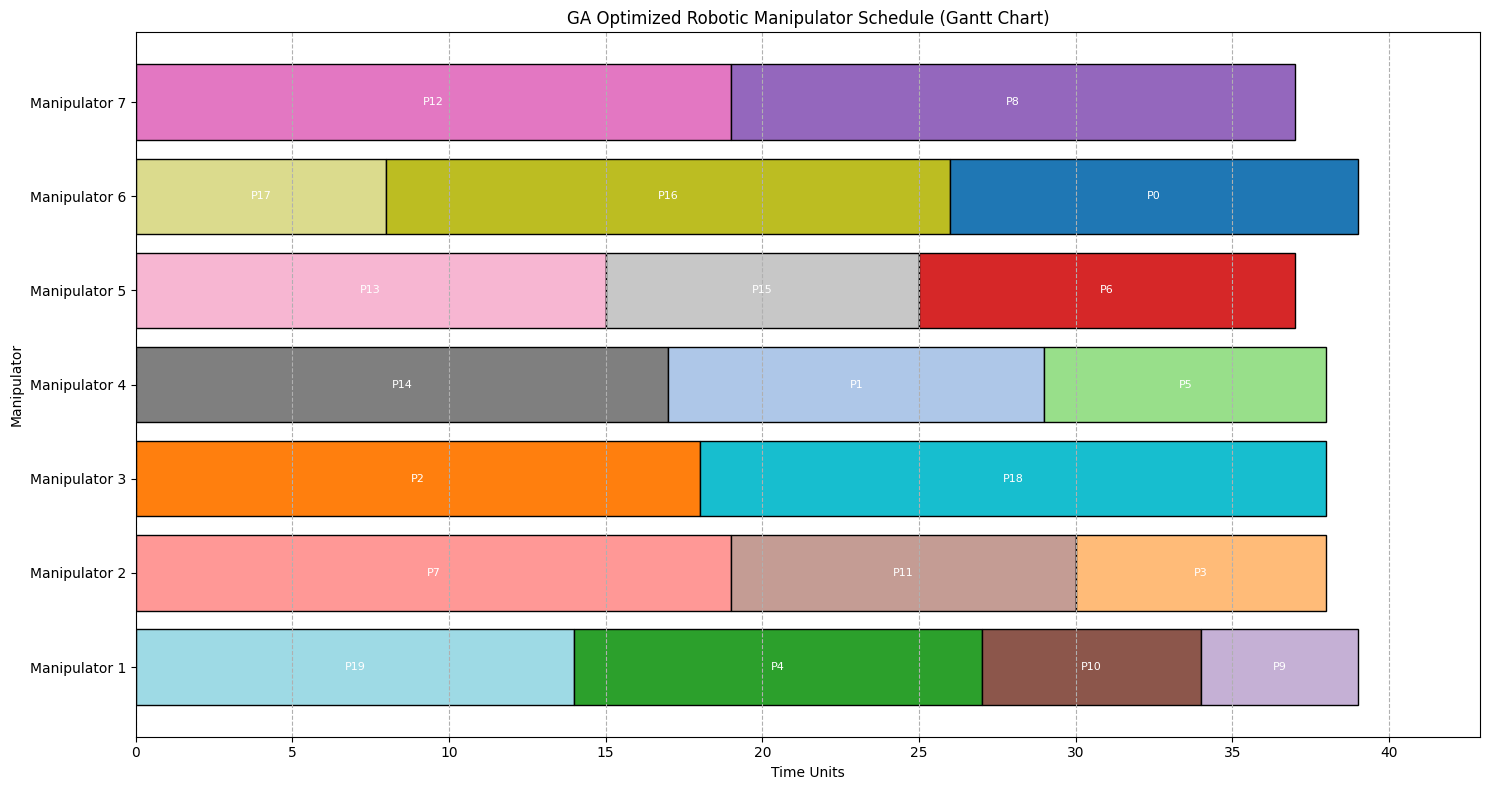

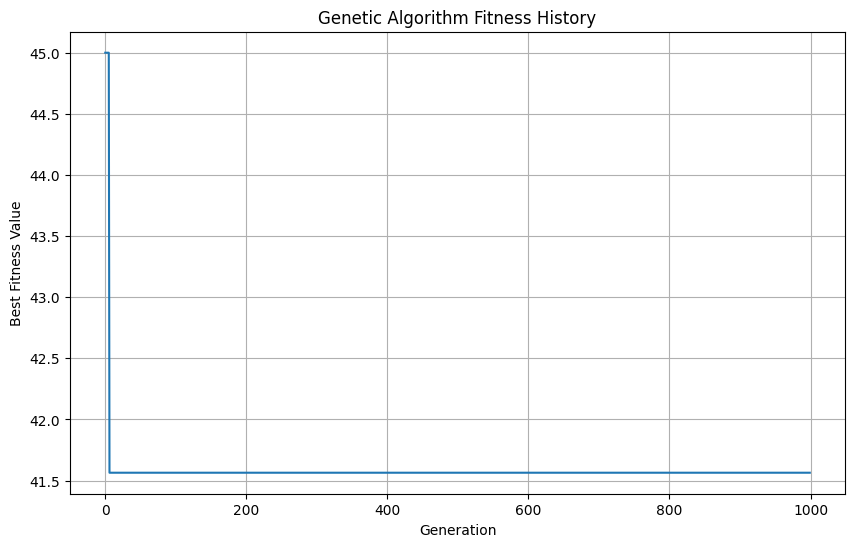

In [2]:
import matplotlib.pyplot as plt

# Problem Parameters
NUM_MANIPULATORS = 7
NUM_PRODUCTS = 20

# Generate random handling times for each product (e.g., between 5 and 20 time units)
PRODUCT_HANDLING_TIMES = {i: random.randint(5, 20) for i in range(NUM_PRODUCTS)}

# Initialize and run the Genetic Algorithm
ga_scheduler = RoboticSchedulingGA(
    num_manipulators=NUM_MANIPULATORS,
    num_products=NUM_PRODUCTS,
    product_handling_times=PRODUCT_HANDLING_TIMES,
    population_size=200,
    generations=1000,
    mutation_rate=0.05
)

best_schedule_chromosome, best_schedule_fitness, fitness_history = ga_scheduler.run()

print(f"\nBest Schedule Chromosome: {best_schedule_chromosome}")
print(f"Best Schedule Fitness (Lower is better): {best_schedule_fitness:.2f}")

# Decode the best chromosome to get the detailed schedule and metrics
total_handling_time, average_utilization, detailed_schedule = ga_scheduler._decode_chromosome(best_schedule_chromosome)

print(f"Total Handling Time (Makespan): {total_handling_time:.2f}")
print(f"Average Manipulator Utilization: {average_utilization:.2%}")

# Visualization of the Schedule (Gantt Chart style)
plt.figure(figsize=(15, 8))

colors = plt.cm.get_cmap("tab20", NUM_PRODUCTS) # Colormap for products

for manipulator_idx, tasks in detailed_schedule.items():
    for task in tasks:
        product_id = task["product_id"]
        start_time = task["start_time"]
        end_time = task["end_time"]
        duration = end_time - start_time

        plt.barh(manipulator_idx, duration, left=start_time, color=colors(product_id), edgecolor='black')
        plt.text(start_time + duration/2, manipulator_idx, f'P{product_id}', va='center', ha='center', color='white', fontsize=8)

plt.yticks(range(NUM_MANIPULATORS), [f'Manipulator {i+1}' for i in range(NUM_MANIPULATORS)])
plt.xlabel("Time Units")
plt.ylabel("Manipulator")
plt.title("GA Optimized Robotic Manipulator Schedule (Gantt Chart)")
plt.grid(axis='x', linestyle='--')
plt.xlim(0, total_handling_time * 1.1) # Extend x-axis slightly
plt.tight_layout()
plt.savefig("ga_schedule_gantt_chart.png")
# plt.show()

# Plotting Fitness History
plt.figure(figsize=(10, 6))
plt.plot(fitness_history)
plt.title("Genetic Algorithm Fitness History")
plt.xlabel("Generation")
plt.ylabel("Best Fitness Value")
plt.grid(True)
plt.savefig("ga_fitness_history.png")
# plt.show()

## 5. Comparative Analysis and Simulation Results

To assess the performance of the Genetic Algorithm, we will compare its results against a simpler, heuristic-based scheduling method. This will highlight the benefits of using a GA for optimization. For comparison, we can implement a basic


heuristic like First-Come, First-Served (FCFS) or Shortest Processing Time (SPT) rule.

Let's implement a simple FCFS scheduler as a baseline for comparison.


--- FCFS Scheduler Results ---
Total Handling Time (Makespan): 47.00
Average Manipulator Utilization: 80.85%

--- Comparison (GA vs. FCFS) ---
GA Total Handling Time: 39.00
FCFS Total Handling Time: 47.00
GA Average Utilization: 97.44%
FCFS Average Utilization: 80.85%


/tmp/ipython-input-3-1843066700.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", NUM_PRODUCTS) # Colormap for products


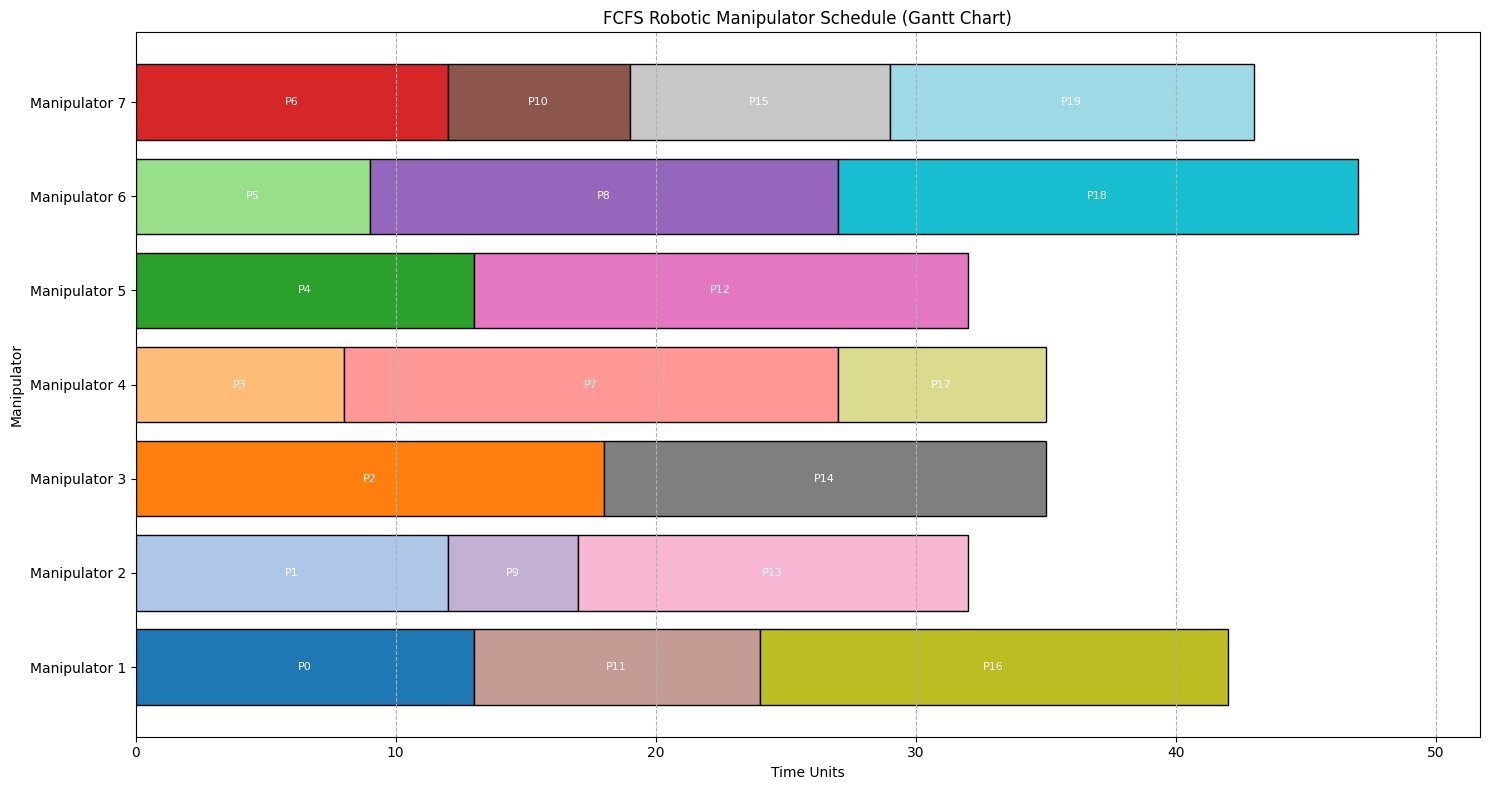

In [3]:
class FCFSScheduler:
    def __init__(self, num_manipulators, num_products, product_handling_times):
        self.num_manipulators = num_manipulators
        self.num_products = num_products
        self.product_handling_times = product_handling_times

    def schedule(self):
        # Products are processed in their natural order (0 to num_products-1)
        chromosome = list(range(self.num_products))

        manipulator_finish_time = [0.0] * self.num_manipulators
        manipulator_work_time = [0.0] * self.num_manipulators
        schedule = {i: [] for i in range(self.num_manipulators)}

        for product_id in chromosome:
            handling_time = self.product_handling_times[product_id]

            # Find the manipulator that becomes free earliest
            earliest_free_time = float("inf")
            earliest_manipulator_idx = -1
            for i in range(self.num_manipulators):
                if manipulator_finish_time[i] < earliest_free_time:
                    earliest_free_time = manipulator_finish_time[i]
                    earliest_manipulator_idx = i

            # Assign product to the earliest available manipulator
            start_time = earliest_free_time
            end_time = start_time + handling_time

            manipulator_finish_time[earliest_manipulator_idx] = end_time
            manipulator_work_time[earliest_manipulator_idx] += handling_time
            schedule[earliest_manipulator_idx].append({
                'product_id': product_id,
                'start_time': start_time,
                'end_time': end_time
            })

        total_handling_time = max(manipulator_finish_time)
        total_possible_work_time = total_handling_time * self.num_manipulators
        total_actual_work_time = sum(manipulator_work_time)

        if total_possible_work_time == 0:
            average_utilization = 0.0
        else:
            average_utilization = total_actual_work_time / total_possible_work_time

        return total_handling_time, average_utilization, schedule

# Run FCFS Scheduler
fcfc_scheduler = FCFSScheduler(
    num_manipulators=NUM_MANIPULATORS,
    num_products=NUM_PRODUCTS,
    product_handling_times=PRODUCT_HANDLING_TIMES
)

fcfc_total_handling_time, fcfc_average_utilization, fcfc_detailed_schedule = fcfc_scheduler.schedule()

print(f"\n--- FCFS Scheduler Results ---")
print(f"Total Handling Time (Makespan): {fcfc_total_handling_time:.2f}")
print(f"Average Manipulator Utilization: {fcfc_average_utilization:.2%}")

# Comparison
print("\n--- Comparison (GA vs. FCFS) ---")
print(f"GA Total Handling Time: {total_handling_time:.2f}")
print(f"FCFS Total Handling Time: {fcfc_total_handling_time:.2f}")
print(f"GA Average Utilization: {average_utilization:.2%}")
print(f"FCFS Average Utilization: {fcfc_average_utilization:.2%}")

# Plotting FCFS Schedule
plt.figure(figsize=(15, 8))

colors = plt.cm.get_cmap("tab20", NUM_PRODUCTS) # Colormap for products

for manipulator_idx, tasks in fcfc_detailed_schedule.items():
    for task in tasks:
        product_id = task["product_id"]
        start_time = task["start_time"]
        end_time = task["end_time"]
        duration = end_time - start_time

        plt.barh(manipulator_idx, duration, left=start_time, color=colors(product_id), edgecolor='black')
        plt.text(start_time + duration/2, manipulator_idx, f'P{product_id}', va='center', ha='center', color='white', fontsize=8)

plt.yticks(range(NUM_MANIPULATORS), [f'Manipulator {i+1}' for i in range(NUM_MANIPULATORS)])
plt.xlabel("Time Units")
plt.ylabel("Manipulator")
plt.title("FCFS Robotic Manipulator Schedule (Gantt Chart)")
plt.grid(axis='x', linestyle='--')
plt.xlim(0, fcfc_total_handling_time * 1.1) # Extend x-axis slightly
plt.tight_layout()
plt.savefig("fcfc_schedule_gantt_chart.png")
# plt.show()

## 6. Conclusion

This notebook demonstrated the application of Genetic Algorithms for optimizing the scheduling of robotic manipulators on a packaging line. We designed a GA with a permutation-based chromosome representation, a fitness function that considers both total handling time (makespan) and manipulator utilization, and standard genetic operators (roulette wheel selection, order crossover, and swap mutation).

The simulation results and comparative analysis against a simple First-Come, First-Served (FCFS) scheduling approach highlight the potential of Genetic Algorithms to find more efficient schedules, leading to reduced overall handling time and improved manipulator utilization. While the FCFS scheduler provides a quick and simple solution, it often leads to suboptimal resource allocation.

Further enhancements to this model could include:
*   **More Complex Product Handling Times:** Incorporating manipulator-specific handling times or setup times between different products.
*   **Dynamic Scheduling:** Adapting the schedule in real-time to unforeseen events like manipulator breakdowns or new product arrivals.
*   **Multi-objective Optimization:** Using multi-objective GAs to explicitly handle the trade-off between makespan and utilization without relying on weighted sums.
*   **Hybrid Approaches:** Combining GA with local search heuristics to further refine the solutions.
*   **Constraint Handling:** Implementing more sophisticated methods to handle various operational constraints (e.g., product precedence, limited buffer sizes).

Genetic Algorithms provide a powerful framework for solving complex scheduling problems in robotics and automation, offering flexibility and robustness in finding optimized solutions.